<a href="https://colab.research.google.com/github/gibranfp/CursoAprendizajeProfundo/blob/2022-1/notebooks/6d_cifar_dcgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generación de imágenes con DCGAN


Curso: [Aprendizaje Profundo](http://turing.iimas.unam.mx/~gibranfp/cursos/aprendizaje_profundo/). Profesor: [Gibran Fuentes Pineda](http://turing.iimas.unam.mx/~gibranfp/). Ayudantes: [Bere](https://turing.iimas.unam.mx/~bereml/) y [Ricardo](https://turing.iimas.unam.mx/~ricardoml/).

---
---

En esta libreta veremos un ejemplo de generación de imágenes utilizando una red generativa adversaria en PyTorch, esta basado en *[Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/abs/1511.06434)*.

## 1 Preparación

### 1.1 Bibliotecas

In [1]:
# funciones aleatorias
import random

# gráficas
import matplotlib.pyplot as plt
# arreglos multidimensionales
import numpy as np
# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# imágenes
from skimage import io
# redes neuronales
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR10
# barras de progreso
from tqdm.auto import tqdm, trange

# reproducibilidad
torch.backends.cudnn.deterministic = True

### 1.2 Auxiliares

In [2]:
def display_grid(xs, rows, cols, figsize=(12, 6)):
    """Despliega un ejempos en una cuadrícula."""
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    i = 0
    for r in range(rows):
        for c in range(cols):
            ax[r, c].imshow(xs[i])
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
            i += 1
    fig.tight_layout()
    plt.show()


def display_batch(x, rows, cols, figsize=(12, 6)):
    """Despliega un lote en una cuadrícula."""
    # denormalizamos
    for c, (mean, std) in enumerate(zip(MEAN, STD)):
        x[:, c] = x[:, c] * std + mean 
    x *= 255
    # rotamos canales
    x = x.permute(0, 2, 3, 1)
    # convertimos a entero
    x = (x.numpy()).astype(np.uint8)

    display_grid(x, rows, cols, figsize)

    
def weights_init(m):
    """Iniciliza"""
    # del artículo de DCGAN [1]
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

## 2 Datos

### 2.1 Tuberias de datos

Files already downloaded and verified
x shape=torch.Size([32, 3, 32, 32]) dtype=torch.float32


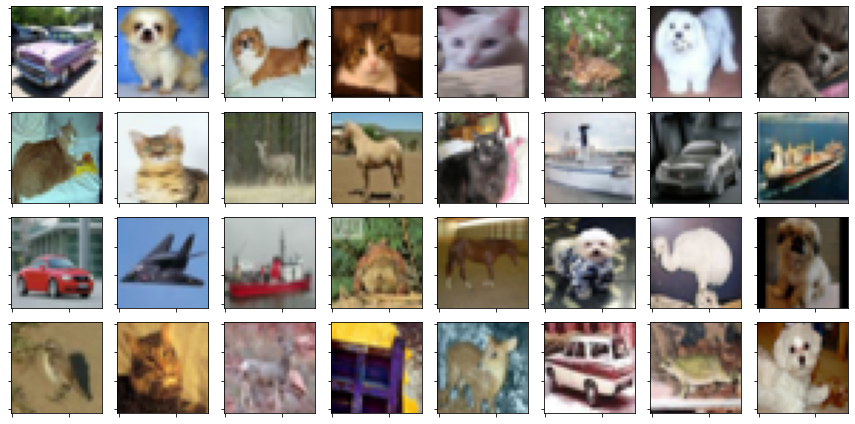

In [3]:
# directorio de datos
DATA_DIR = '../data'
# media y desviación estandar 
MEAN = (0.5, 0.5, 0.5)
STD = (0.5, 0.5, 0.5)
# filas y columnas de la cuadricula 
ROWS, COLS = 4, 8
# tamaño del lote
BATCH_SIZE = 32


# transformaciones para la imagen
tsfm = transforms.Compose([
    # convertimos a torch.Tensor y escalamos a [0,1]
    transforms.ToTensor(),
    # estandarizamos: restamos la media y dividimos sobre la varianza
    transforms.Normalize(MEAN, STD),
])

# creamos un Dataset
ds = CIFAR10(
    # directorio de datos
    root=DATA_DIR,
    # subconjunto de entrenamiento
    train=True,
    # descarga de datos
    download=True,
    # transformación
    transform=tsfm
)

# creamos el cargador de datos
dl = DataLoader(
    # conjunto
    ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

# desplegamos un lote de imágenes
x, _ = next(iter(dl))
print(f'x shape={x.shape} dtype={x.dtype}')
display_batch(x, ROWS, COLS)

## 3 Modelo

### 3.1 Definición de red generadora

In [4]:
class Generator(nn.Module):

    def __init__(self):
        super(Generator, self).__init__()

        # [N, 100, 1, 1] => [N, 3, 64, 64]
        self.net = nn.Sequential(

            # [N, 100, 1, 1] => [N, 256, 4, 4]
            nn.ConvTranspose2d(100, 256, 4, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            # [N, 256, 4, 4] => [N, 128, 8, 8]
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            # [N, 128, 8, 8] => [N, 64, 16, 16]
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            # [N, 64, 32, 32] => [N, 3, 32, 32]
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.net(x)


z = torch.zeros(1, 100, 1, 1)
x = Generator()(z)
f'{z.shape} => {x.shape}'

'torch.Size([1, 100, 1, 1]) => torch.Size([1, 3, 32, 32])'

### 3.2 Definición de red discriminadora

In [5]:
class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()

        self.net = nn.Sequential(

            # [N, 3, 32, 32] => [N, 32, 16, 16]
            nn.Conv2d(3, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            
            # [N, 32, 16, 16] => [N, 64, 8, 8]
            nn.Conv2d(32, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            # [N, 64, 8, 8] => [N, 128, 4, 4]
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # [N, 128, 4, 4] => [N, 1, 1, 1]
            nn.Conv2d(128, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
            
            # [N, 1, 1, 1] => [N, 1]
            nn.Flatten(),
        )       

    # metodo para inferencia
    def forward(self, x):
        return self.net(x)


x = torch.zeros(1, 3, 32, 32)
y = Discriminator()(x)
f'{x.shape} => {y.shape}'

'torch.Size([1, 3, 32, 32]) => torch.Size([1, 1])'

## 4 Entrenamiento

### 4.1 Ciclo de entrenamiento

In [6]:
def forward_backward(imgs, batch_size, label, dis, device):
    """Propaga hacía adelante un lote de imágenes sobre la discriminadora 
       y retropropaga la gráfica de cómputo."""
    # creamos etiquetas
    y_true = torch.full([batch_size], label, dtype=torch.float, device=device)
    # predecimos etiquetas
    y_pred = dis(imgs).view(-1)
    # calculamos la pérdida
    loss = F.binary_cross_entropy(y_pred, y_true)
    # retropropagamos para la discriminadora
    loss.backward()
    return loss.item()


def train(dl, gen, dis,
          fake_label=0, real_label=1, epochs=50,
          # hiperparámetros del artículo
          beta1=0.5, lr=0.0002, z_size=100,
          fake_imgs_save_freq=5,
    ):
    """Entrena la redes discriminadora y generadora."""
    
    # inicializamos redes
    gen.apply(weights_init)
    dis.apply(weights_init)

    # movemos a dispositivo
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    gen.to(device)
    dis.to(device)

    # optimizadores
    gen_opt = optim.Adam(gen.parameters(), lr=lr, betas=(beta1, 0.999))
    dis_opt = optim.Adam(dis.parameters(), lr=lr, betas=(beta1, 0.999))

    # historiales de pérdidas
    gen_losses, dis_losses = [], []
    fake_imgs_hist = []

    # ciclo de entrenamiento
    for epoch in trange(epochs):
        
        epoch_gen_losses, epoch_dis_losses = [], []
        
        for real_imgs, _ in dl:

            batch_size = real_imgs.shape[0]
            real_imgs = real_imgs.to(device)

            ############################
            # (1) entrenamos la discriminadora: max log(D(x)) + log(1 - D(G(z)))
            
            # ponemos en cero los gradientes de la discriminadora
            dis.zero_grad()
            
            # (1.a) entrenamos con imágenes reales
            # propagamos con imágenes reales
            # y retropropagamos el error solo a la red discriminadora
            dis_real_loss = forward_backward(
                real_imgs, batch_size, real_label, dis, device)
            
            # (1.b) entrenamos con imágenes falsas
            # muestreamos el espacio latente
            z = torch.randn(batch_size, z_size, 1, 1, device=device)
            # generamos imágenes falsas (propagamos)
            fake_imgs = gen(z)
            # desconectamos el tensor de la gráfica de cómputo
            fake_imgs_detached = fake_imgs.detach()
            # propagamos con imágenes falsas
            # y retropropagamos el error solo a la red discriminadora
            dis_fake_loss = forward_backward(
                fake_imgs_detached, batch_size, fake_label, dis, device)
            
            # (1.c) actualizamos los parámetros de la discriminadora
            dis_opt.step()

            # pérdida global de la discriminadora
            dis_loss = dis_real_loss + dis_fake_loss

            ############################
            # (2) entrenamos la generadora: max log(D(G(z)))
            # ponemos en cero los gradientes de la generadora
            gen.zero_grad()
            # propagamos con imágenes falsas
            # y retropropagamos el error hasta la red generadora
            gen_loss = forward_backward(
                fake_imgs, batch_size, real_label, dis, device)
            # actualizamos los parámetros de la generadora
            gen_opt.step()

            # guardamos pérdidas
            gen_loss *= 100
            dis_loss *= 100            
            # pérdidas por época
            epoch_gen_losses.append(gen_loss)
            epoch_dis_losses.append(dis_loss)
            # historial de pérdidas
            gen_losses.append(gen_loss)
            dis_losses.append(dis_loss)
            
        if epoch % fake_imgs_save_freq == 0:
            fake_imgs_hist.append([epoch, fake_imgs_detached.cpu()])

        print(f'[{epoch:2d}/{epochs}] '
              f'gen_loss={np.mean(epoch_gen_losses):7.3f} '
              f'dis_loss={np.mean(epoch_dis_losses):7.3f}')

    return gen_losses, dis_losses, fake_imgs_hist

set_seed()
gen = Generator()
dis = Discriminator()
gen_losses, dis_losses, fake_imgs_hist = train(dl, gen, dis, epochs=25, fake_imgs_save_freq=5)

  0%|          | 0/25 [00:00<?, ?it/s]

KeyboardInterrupt: 

### 4.2 Pérdidas durante entrenamiento

In [ ]:
plt.figure(figsize=(10,5))
plt.title('Pérdidas de la generadora y la discriminadora durante el entrenamiento')
plt.plot(gen_losses, label='gen')
plt.plot(dis_losses, label='dis')
plt.xlabel('pasos')
plt.ylabel('pérdida')
plt.legend()
plt.show()

### 4.3 Imágenes generadas durante entrenamiento

In [ ]:
for epoch, fake_imgs in fake_imgs_hist:
    rows = fake_imgs.shape[0] // COLS
    print(f'Generated images at epoch {epoch}')
    display_batch(fake_imgs, rows, COLS, figsize=(12, 3))

### 4.4 Imágenes finales

In [ ]:
gen = gen.cpu().eval()
with torch.no_grad():
    z = torch.randn(ROWS * COLS, 100, 1, 1)
    fake_imgs = gen(z)
display_batch(fake_imgs, ROWS, COLS)